C:\Users\tfeder\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0425
Epoch 2/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0182
Epoch 3/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0155
Epoch 4/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0158
Epoch 5/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0146
Epoch 6/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0122
Epoch 7/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0119
Epoch 8/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0114
Epoch 9/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0123
Epoch 10/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0101
Test Loss: 0.0028003056067973375
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
RMSE: 2703.303397020123
MAE: 2277.7783582630773
R²: -1.4594227983333377


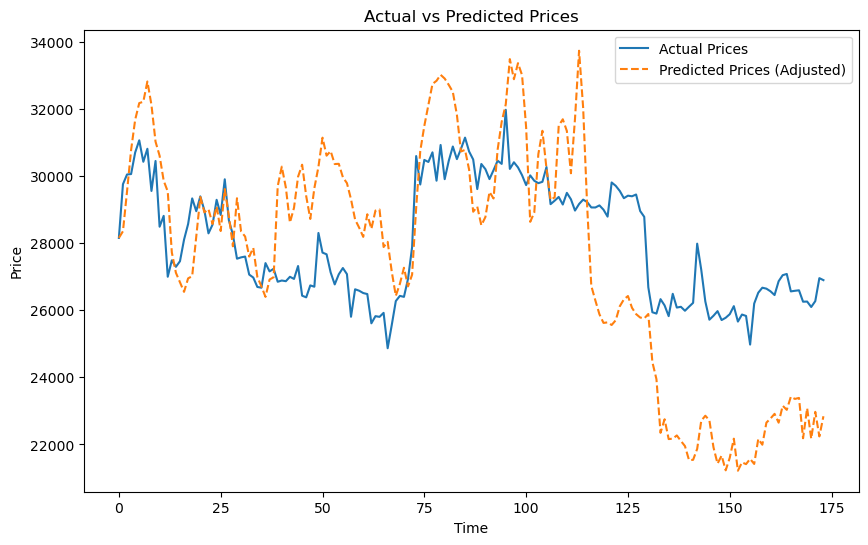

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the data
file_path = r"C:\Users\tfeder\Documents\M2 CLASSES\Master Thesis\AAVE_Data\Questions\Tokens_no_lags\WBTC_data_with_pagerank_final_cleaned.csv"
data = pd.read_csv(file_path)

# List of original day t columns to be removed (including PageRank columns)
columns_to_remove = ['balanceUSD', 'totalValueLockedUSD', 'totalBorrowBalanceUSD', 
                     'variableBorrowRate', 'stableBorrowRate', 'supplyRate',
                     'avg_pagerank', 'total_pagerank']

# Create lagged features for relevant columns (including the two PageRank columns)
lag_features = ['balanceUSD', 'totalValueLockedUSD', 'totalBorrowBalanceUSD', 
                'variableBorrowRate', 'stableBorrowRate', 'supplyRate',
                'avg_pagerank', 'total_pagerank']

# Generate lagged features for the past 1, 2, and 3 days
for feature in lag_features:
    data[f'{feature}_lag1'] = data[feature].shift(1)
    data[f'{feature}_lag2'] = data[feature].shift(2)
    data[f'{feature}_lag3'] = data[feature].shift(3)

# Drop rows with NaN values generated due to lagging
data_with_lags = data.dropna()

# Drop the day t columns
data_for_lstm = data_with_lags.drop(columns=columns_to_remove)

# Prepare data for LSTM
data_for_lstm_numeric = data_for_lstm.drop(columns=['timestamp', 'token', 'id', 'date'])

# Split into features (X) and target (y)
X = data_for_lstm_numeric.drop(columns=['inputTokenPriceUSD']).values
y = data_for_lstm_numeric['inputTokenPriceUSD'].values

# Scale the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Reshape X for LSTM model (samples, timesteps, features)
X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_scaled, test_size=0.2, random_state=42, shuffle=False)

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, batch_size=1, epochs=10, verbose=1)

# Evaluate the model on the test data
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss}")

# Predicting the test set
y_pred_scaled = model.predict(X_test)

# Inverse transform y_test and y_pred to original values
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Adjust the prediction to start at the same point as the actual values
offset = y_test_original[0] - y_pred[0]
y_pred_adjusted = y_pred + offset

# Calculate performance metrics
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_adjusted))
mae = mean_absolute_error(y_test_original, y_pred_adjusted)
r2 = r2_score(y_test_original, y_pred_adjusted)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

# Plot actual vs adjusted predicted prices
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Actual Prices')
plt.plot(y_pred_adjusted, label='Predicted Prices (Adjusted)', linestyle='--')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


Epoch 1/10


C:\Users\tfeder\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


716/716 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0433
Epoch 2/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0178
Epoch 3/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0150
Epoch 4/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0129
Epoch 5/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0137
Epoch 6/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0108
Epoch 7/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0117
Epoch 8/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0124
Epoch 9/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0126
Epoch 10/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0106
Test Loss: 0.0024360150564461946
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
Epoch 1/10


C:\Users\tfeder\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


692/692 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0424
Epoch 2/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0194
Epoch 3/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0190
Epoch 4/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0160
Epoch 5/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0136
Epoch 6/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0132
Epoch 7/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0107
Epoch 8/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0120
Epoch 9/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0103
Epoch 10/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0113
Test Loss: 0.005295317154377699
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 288ms/step


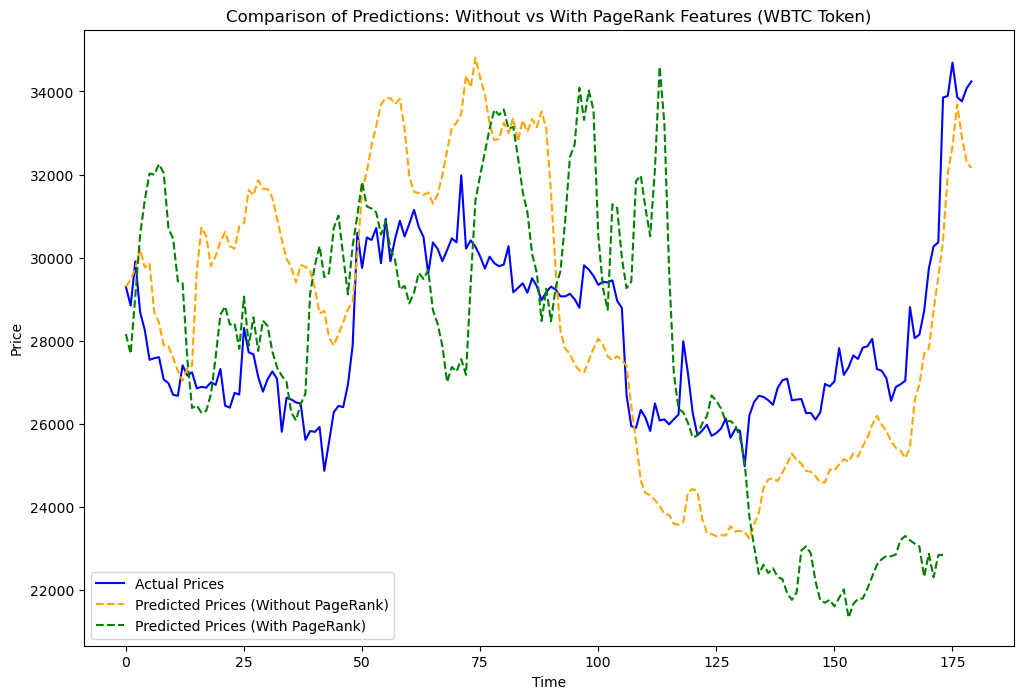

In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def load_and_process_data(file_path, lag_features, columns_to_remove):
    data = pd.read_csv(file_path)
    
    # Generate lagged features for the past 1, 2, and 3 days
    for feature in lag_features:
        data[f'{feature}_lag1'] = data[feature].shift(1)
        data[f'{feature}_lag2'] = data[feature].shift(2)
        data[f'{feature}_lag3'] = data[feature].shift(3)

    # Drop rows with NaN values generated due to lagging
    data_with_lags = data.dropna()

    # Drop the day t columns
    data_for_lstm = data_with_lags.drop(columns=columns_to_remove)

    # Drop non-numeric columns that are not needed for LSTM model
    data_for_lstm_numeric = data_for_lstm.drop(columns=['timestamp', 'token', 'id', 'date'])

    # Split into features (X) and target (y)
    X = data_for_lstm_numeric.drop(columns=['inputTokenPriceUSD']).values
    y = data_for_lstm_numeric['inputTokenPriceUSD'].values

    return X, y

def build_and_train_model(X, y):
    # Scale the data
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

    # Reshape X for LSTM model (samples, timesteps, features)
    X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_scaled, test_size=0.2, random_state=42, shuffle=False)

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    history = model.fit(X_train, y_train, batch_size=1, epochs=10, verbose=1)

    # Evaluate the model on the test data
    loss = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {loss}")

    # Predicting the test set
    y_pred_scaled = model.predict(X_test)

    # Inverse transform y_test and y_pred to original values
    y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    # Adjust the prediction to start at the same point as the actual values
    offset = y_test_original[0] - y_pred[0]
    y_pred_adjusted = y_pred + offset

    return y_test_original, y_pred_adjusted

# File paths for data
file_path_without_pagerank = r"C:\Users\tfeder\Documents\M2 CLASSES\Master Thesis\AAVE_Data\Questions\Tokens_no_lags\WBTC_full_data_final_cleaned.csv"
file_path_with_pagerank = r"C:\Users\tfeder\Documents\M2 CLASSES\Master Thesis\AAVE_Data\Questions\Tokens_no_lags\WBTC_data_with_pagerank_final_cleaned.csv"

# Define columns to lag and remove
columns_to_remove_without = ['balanceUSD', 'totalValueLockedUSD', 'totalBorrowBalanceUSD', 
                             'variableBorrowRate', 'stableBorrowRate', 'supplyRate']

columns_to_remove_with = columns_to_remove_without + ['avg_pagerank', 'total_pagerank']

lag_features_without = columns_to_remove_without
lag_features_with = lag_features_without + ['avg_pagerank', 'total_pagerank']

# Process and train the model without PageRank features
X_without, y_without = load_and_process_data(file_path_without_pagerank, lag_features_without, columns_to_remove_without)
y_test_original_without, y_pred_adjusted_without = build_and_train_model(X_without, y_without)

# Process and train the model with PageRank features
X_with, y_with = load_and_process_data(file_path_with_pagerank, lag_features_with, columns_to_remove_with)
y_test_original_with, y_pred_adjusted_with = build_and_train_model(X_with, y_with)

# Plot comparison
plt.figure(figsize=(12, 8))
plt.plot(y_test_original_without, label='Actual Prices', color='blue')
plt.plot(y_pred_adjusted_without, label='Predicted Prices (Without PageRank)', linestyle='--', color='orange')
plt.plot(y_pred_adjusted_with, label='Predicted Prices (With PageRank)', linestyle='--', color='green')
plt.title('Comparison of Predictions: Without vs With PageRank Features (WBTC Token)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


Epoch 1/10


C:\Users\tfeder\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


716/716 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0314
Epoch 2/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0159
Epoch 3/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0152
Epoch 4/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0135
Epoch 5/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0130
Epoch 6/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0124
Epoch 7/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0128
Epoch 8/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0113
Epoch 9/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0103
Epoch 10/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0097
Test Loss: 0.00993265025317669
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
Epoch 1/10


C:\Users\tfeder\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


692/692 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0487
Epoch 2/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0162
Epoch 3/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0146
Epoch 4/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0109
Epoch 5/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0126
Epoch 6/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0110
Epoch 7/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0121
Epoch 8/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0102
Epoch 9/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0096
Epoch 10/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0112
Test Loss: 0.011966073885560036
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


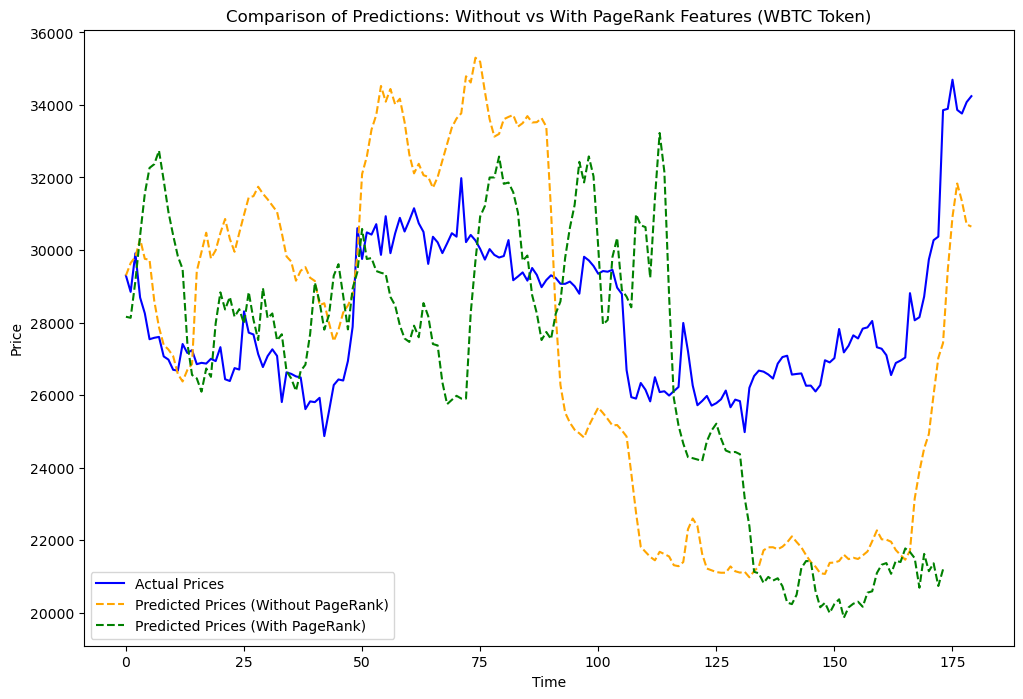

In [5]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def load_and_process_data(file_path, lag_features, columns_to_remove):
    data = pd.read_csv(file_path)
    
    # Generate lagged features for the past 1, 2, and 3 days
    for feature in lag_features:
        data[f'{feature}_lag1'] = data[feature].shift(1)
        data[f'{feature}_lag2'] = data[feature].shift(2)
        data[f'{feature}_lag3'] = data[feature].shift(3)

    # Drop rows with NaN values generated due to lagging
    data_with_lags = data.dropna()

    # Drop the day t columns
    data_for_lstm = data_with_lags.drop(columns=columns_to_remove)

    # Drop non-numeric columns that are not needed for LSTM model
    data_for_lstm_numeric = data_for_lstm.drop(columns=['timestamp', 'token', 'id', 'date'])

    # Split into features (X) and target (y)
    X = data_for_lstm_numeric.drop(columns=['inputTokenPriceUSD']).values
    y = data_for_lstm_numeric['inputTokenPriceUSD'].values

    return X, y

def build_and_train_model(X, y):
    # Scale the data
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

    # Reshape X for LSTM model (samples, timesteps, features)
    X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_scaled, test_size=0.2, random_state=42, shuffle=False)

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    history = model.fit(X_train, y_train, batch_size=1, epochs=10, verbose=1)

    # Evaluate the model on the test data
    loss = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {loss}")

    # Predicting the test set
    y_pred_scaled = model.predict(X_test)

    # Inverse transform y_test and y_pred to original values
    y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    # Adjust the prediction to start at the same point as the actual values
    offset = y_test_original[0] - y_pred[0]
    y_pred_adjusted = y_pred + offset

    return y_test_original, y_pred_adjusted

# File paths for data
file_path_without_pagerank = r"C:\Users\tfeder\Documents\M2 CLASSES\Master Thesis\AAVE_Data\Questions\Tokens_no_lags\WBTC_full_data_final_cleaned.csv"
file_path_with_pagerank = r"C:\Users\tfeder\Documents\M2 CLASSES\Master Thesis\AAVE_Data\Questions\Tokens_no_lags\WBTC_data_with_pagerank_final_cleaned.csv"

# Define columns to lag and remove
columns_to_remove_without = ['balanceUSD', 'totalValueLockedUSD', 'totalBorrowBalanceUSD', 
                             'variableBorrowRate', 'stableBorrowRate', 'supplyRate']

columns_to_remove_with = columns_to_remove_without + ['avg_pagerank', 'total_pagerank']

lag_features_without = columns_to_remove_without
lag_features_with = lag_features_without + ['avg_pagerank', 'total_pagerank']

# Process and train the model without PageRank features
X_without, y_without = load_and_process_data(file_path_without_pagerank, lag_features_without, columns_to_remove_without)
y_test_original_without, y_pred_adjusted_without = build_and_train_model(X_without, y_without)

# Process and train the model with PageRank features
X_with, y_with = load_and_process_data(file_path_with_pagerank, lag_features_with, columns_to_remove_with)
y_test_original_with, y_pred_adjusted_with = build_and_train_model(X_with, y_with)

# Plot comparison
plt.figure(figsize=(12, 8))
plt.plot(y_test_original_without, label='Actual Prices', color='blue')
plt.plot(y_pred_adjusted_without, label='Predicted Prices (Without PageRank)', linestyle='--', color='orange')
plt.plot(y_pred_adjusted_with, label='Predicted Prices (With PageRank)', linestyle='--', color='green')
plt.title('Comparison of Predictions: Without vs With PageRank Features (WBTC Token)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


Epoch 1/10


C:\Users\tfeder\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


716/716 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0385
Epoch 2/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0195
Epoch 3/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0174
Epoch 4/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0127
Epoch 5/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0130
Epoch 6/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0151
Epoch 7/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0103
Epoch 8/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0134
Epoch 9/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0118
Epoch 10/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0117
Test Loss: 0.002152753761038184
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
Epoch 1/10


C:\Users\tfeder\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


692/692 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0421
Epoch 2/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0175
Epoch 3/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0151
Epoch 4/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0133
Epoch 5/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0137
Epoch 6/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0109
Epoch 7/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0116
Epoch 8/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0105
Epoch 9/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0103
Epoch 10/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0119
Test Loss: 0.0030927860643714666
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


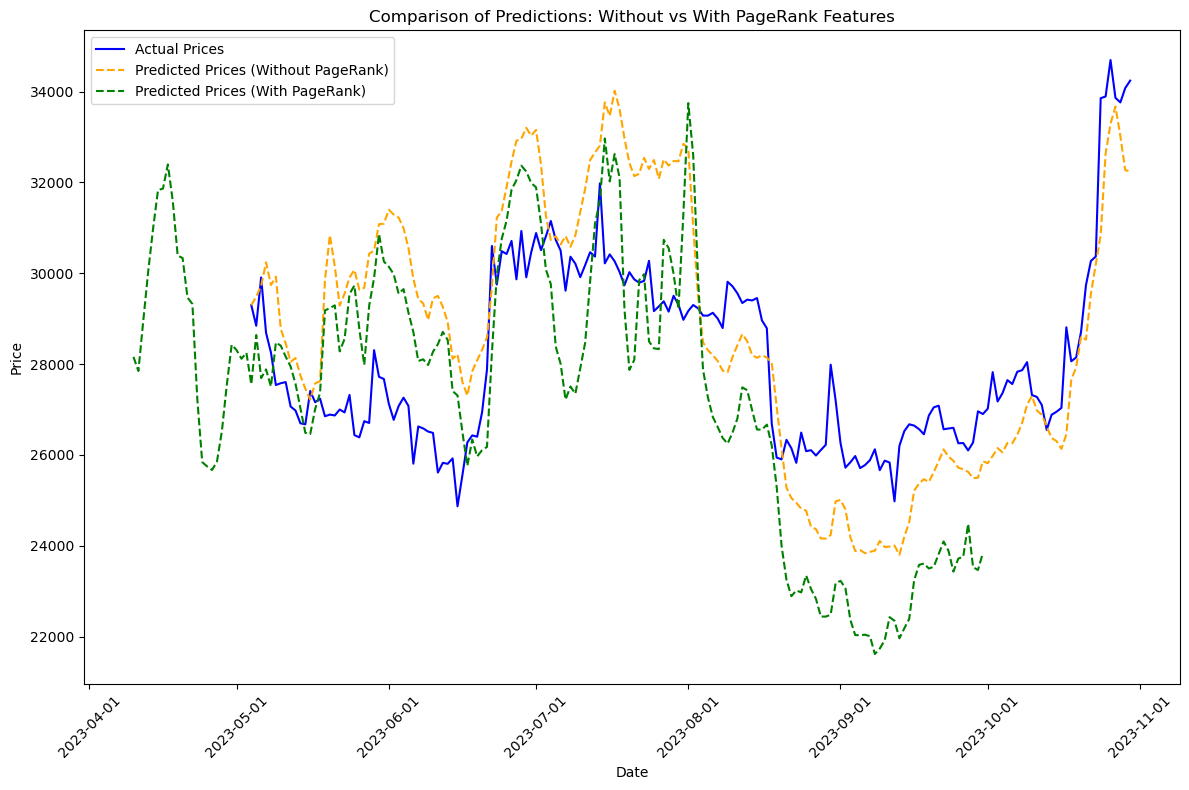

In [9]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, AutoDateLocator

def load_and_process_data(file_path, lag_features, columns_to_remove):
    data = pd.read_csv(file_path)
    
    # Generate lagged features for the past 1, 2, and 3 days
    for feature in lag_features:
        data[f'{feature}_lag1'] = data[feature].shift(1)
        data[f'{feature}_lag2'] = data[feature].shift(2)
        data[f'{feature}_lag3'] = data[feature].shift(3)

    # Drop rows with NaN values generated due to lagging
    data_with_lags = data.dropna()

    # Extract the date column before dropping others
    dates = pd.to_datetime(data_with_lags['date'])

    # Drop the day t columns
    data_for_lstm = data_with_lags.drop(columns=columns_to_remove)

    # Drop non-numeric columns that are not needed for LSTM model
    data_for_lstm_numeric = data_for_lstm.drop(columns=['timestamp', 'token', 'id', 'date'])

    # Split into features (X) and target (y)
    X = data_for_lstm_numeric.drop(columns=['inputTokenPriceUSD']).values
    y = data_for_lstm_numeric['inputTokenPriceUSD'].values

    return X, y, dates

def build_and_train_model(X, y):
    # Scale the data
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

    # Reshape X for LSTM model (samples, timesteps, features)
    X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_scaled, test_size=0.2, random_state=42, shuffle=False)

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    history = model.fit(X_train, y_train, batch_size=1, epochs=10, verbose=1)

    # Evaluate the model on the test data
    loss = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {loss}")

    # Predicting the test set
    y_pred_scaled = model.predict(X_test)

    # Inverse transform y_test and y_pred to original values
    y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    # Adjust the prediction to start at the same point as the actual values
    offset = y_test_original[0] - y_pred[0]
    y_pred_adjusted = y_pred + offset

    return y_test_original, y_pred_adjusted

# File paths for data
file_path_without_pagerank = r"C:\Users\tfeder\Documents\M2 CLASSES\Master Thesis\AAVE_Data\Questions\Tokens_no_lags\WBTC_full_data_final_cleaned.csv"
file_path_with_pagerank = r"C:\Users\tfeder\Documents\M2 CLASSES\Master Thesis\AAVE_Data\Questions\Tokens_no_lags\WBTC_data_with_pagerank_final_cleaned.csv"

# Define columns to lag and remove
columns_to_remove_without = ['balanceUSD', 'totalValueLockedUSD', 'totalBorrowBalanceUSD', 
                             'variableBorrowRate', 'stableBorrowRate', 'supplyRate']
columns_to_remove_with = columns_to_remove_without + ['avg_pagerank', 'total_pagerank']

lag_features_without = columns_to_remove_without
lag_features_with = lag_features_without + ['avg_pagerank', 'total_pagerank']

# Process and train the model without PageRank features
X_without, y_without, dates_without = load_and_process_data(file_path_without_pagerank, lag_features_without, columns_to_remove_without)
y_test_original_without, y_pred_adjusted_without = build_and_train_model(X_without, y_without)

# Process and train the model with PageRank features
X_with, y_with, dates_with = load_and_process_data(file_path_with_pagerank, lag_features_with, columns_to_remove_with)
y_test_original_with, y_pred_adjusted_with = build_and_train_model(X_with, y_with)

# Plot comparison
plt.figure(figsize=(12, 8))
plt.plot(dates_without.iloc[-len(y_test_original_without):], y_test_original_without, label='Actual Prices', color='blue')
plt.plot(dates_without.iloc[-len(y_pred_adjusted_without):], y_pred_adjusted_without, label='Predicted Prices (Without PageRank)', linestyle='--', color='orange')
plt.plot(dates_with.iloc[-len(y_pred_adjusted_with):], y_pred_adjusted_with, label='Predicted Prices (With PageRank)', linestyle='--', color='green')

plt.title('Comparison of Predictions: Without vs With PageRank Features')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Adjust date formatting for better readability
plt.gca().xaxis.set_major_locator(AutoDateLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)  # Rotate the date labels for better readability
plt.tight_layout()
plt.show()


Epoch 1/10


C:\Users\tfeder\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


716/716 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0376
Epoch 2/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0161
Epoch 3/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0156
Epoch 4/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0127
Epoch 5/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0116
Epoch 6/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0117
Epoch 7/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0118
Epoch 8/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0111
Epoch 9/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0093
Epoch 10/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0118
Test Loss: 0.004665605258196592
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
Epoch 1/10


C:\Users\tfeder\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


692/692 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.0437
Epoch 2/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0157
Epoch 3/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0155
Epoch 4/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0143
Epoch 5/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0129
Epoch 6/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0124
Epoch 7/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0109
Epoch 8/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0121
Epoch 9/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0109
Epoch 10/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0109
Test Loss: 0.00325939804315567
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step


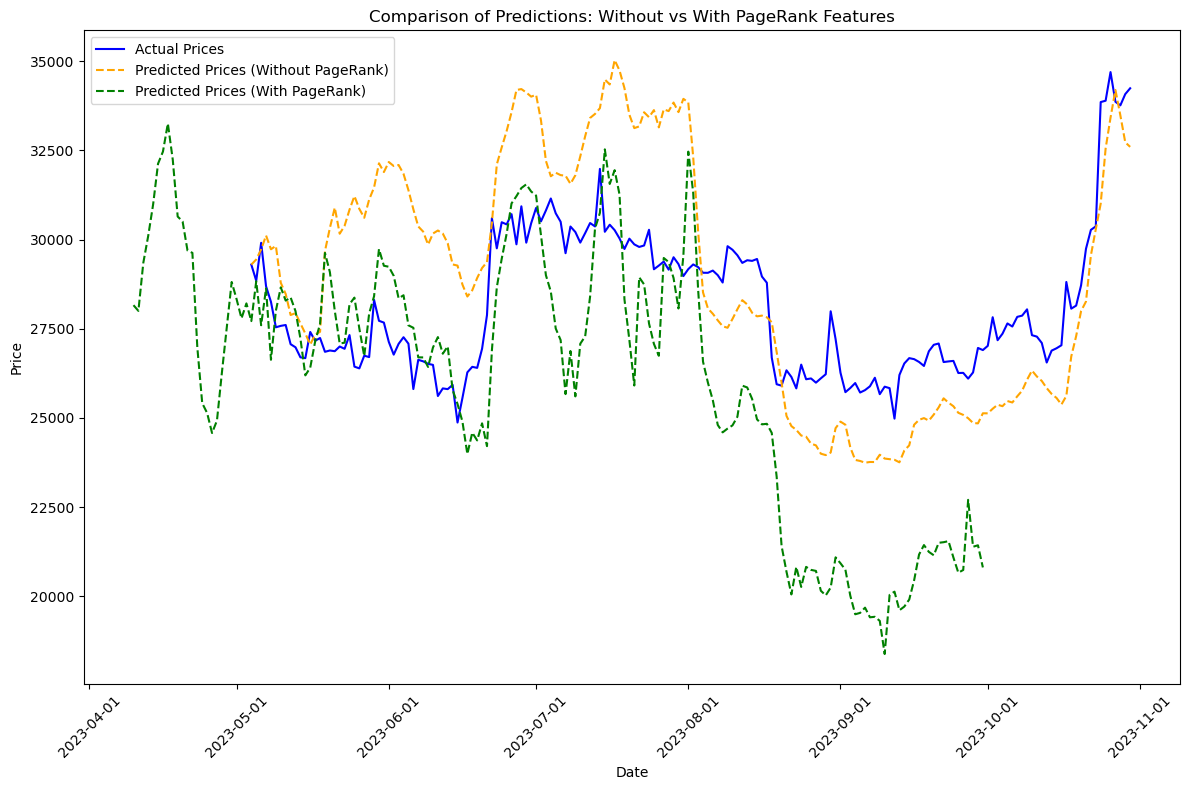

In [10]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, AutoDateLocator

def load_and_process_data(file_path, lag_features, columns_to_remove):
    data = pd.read_csv(file_path)
    
    # Generate lagged features for the past 1, 2, and 3 days
    for feature in lag_features:
        data[f'{feature}_lag1'] = data[feature].shift(1)
        data[f'{feature}_lag2'] = data[feature].shift(2)
        data[f'{feature}_lag3'] = data[feature].shift(3)

    # Drop rows with NaN values generated due to lagging
    data_with_lags = data.dropna()

    # Extract the date column before dropping others
    dates = pd.to_datetime(data_with_lags['date'])

    # Drop the day t columns
    data_for_lstm = data_with_lags.drop(columns=columns_to_remove)

    # Drop non-numeric columns that are not needed for LSTM model
    data_for_lstm_numeric = data_for_lstm.drop(columns=['timestamp', 'token', 'id', 'date'])

    # Split into features (X) and target (y)
    X = data_for_lstm_numeric.drop(columns=['inputTokenPriceUSD']).values
    y = data_for_lstm_numeric['inputTokenPriceUSD'].values

    return X, y, dates

def build_and_train_model(X, y):
    # Scale the data
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

    # Reshape X for LSTM model (samples, timesteps, features)
    X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_scaled, test_size=0.2, random_state=42, shuffle=False)

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    history = model.fit(X_train, y_train, batch_size=1, epochs=10, verbose=1)

    # Evaluate the model on the test data
    loss = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {loss}")

    # Predicting the test set
    y_pred_scaled = model.predict(X_test)

    # Inverse transform y_test and y_pred to original values
    y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    # Adjust the prediction to start at the same point as the actual values
    offset = y_test_original[0] - y_pred[0]
    y_pred_adjusted = y_pred + offset

    return y_test_original, y_pred_adjusted

# File paths for data
file_path_without_pagerank = r"C:\Users\tfeder\Documents\M2 CLASSES\Master Thesis\AAVE_Data\Questions\Tokens_no_lags\WBTC_full_data_final_cleaned.csv"
file_path_with_pagerank = r"C:\Users\tfeder\Documents\M2 CLASSES\Master Thesis\AAVE_Data\Questions\Tokens_no_lags\WBTC_data_with_pagerank_final_cleaned.csv"

# Define columns to lag and remove
columns_to_remove_without = ['balanceUSD', 'totalValueLockedUSD', 'totalBorrowBalanceUSD', 
                             'variableBorrowRate', 'stableBorrowRate', 'supplyRate']
columns_to_remove_with = columns_to_remove_without + ['avg_pagerank', 'total_pagerank']

lag_features_without = columns_to_remove_without
lag_features_with = lag_features_without + ['avg_pagerank', 'total_pagerank']

# Process and train the model without PageRank features
X_without, y_without, dates_without = load_and_process_data(file_path_without_pagerank, lag_features_without, columns_to_remove_without)
y_test_original_without, y_pred_adjusted_without = build_and_train_model(X_without, y_without)

# Process and train the model with PageRank features
X_with, y_with, dates_with = load_and_process_data(file_path_with_pagerank, lag_features_with, columns_to_remove_with)
y_test_original_with, y_pred_adjusted_with = build_and_train_model(X_with, y_with)

# Plot comparison
plt.figure(figsize=(12, 8))
plt.plot(dates_without.iloc[-len(y_test_original_without):], y_test_original_without, label='Actual Prices', color='blue')
plt.plot(dates_without.iloc[-len(y_pred_adjusted_without):], y_pred_adjusted_without, label='Predicted Prices (Without PageRank)', linestyle='--', color='orange')
plt.plot(dates_with.iloc[-len(y_pred_adjusted_with):], y_pred_adjusted_with, label='Predicted Prices (With PageRank)', linestyle='--', color='green')

plt.title('Comparison of Predictions: Without vs With PageRank Features')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Adjust date formatting for better readability
plt.gca().xaxis.set_major_locator(AutoDateLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)  # Rotate the date labels for better readability
plt.tight_layout()
plt.show()


Epoch 1/10


C:\Users\tfeder\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


716/716 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0384
Epoch 2/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0169
Epoch 3/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0124
Epoch 4/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0115
Epoch 5/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0124
Epoch 6/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0098
Epoch 7/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0105
Epoch 8/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0110
Epoch 9/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0095
Epoch 10/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0126
Test Loss: 0.008014218881726265
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step


C:\Users\tfeder\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0290
Epoch 2/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0162
Epoch 3/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0159
Epoch 4/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0140
Epoch 5/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0127
Epoch 6/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0102
Epoch 7/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0112
Epoch 8/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0145
Epoch 9/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0091
Epoch 10/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0090
Test Loss: 0.0052766744047403336
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step
MSE without PageRank features: 11186360.902213497
MSE with PageRank features: 9577067.81678581


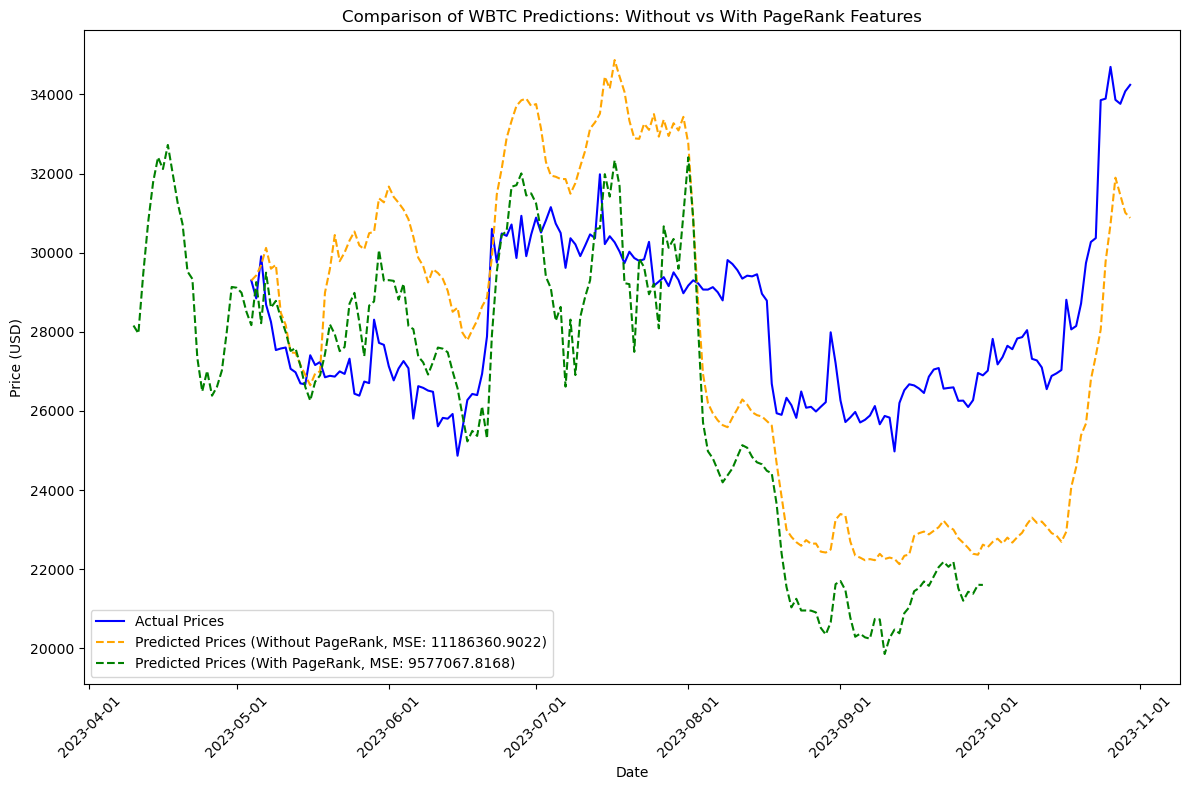

In [11]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, AutoDateLocator
from sklearn.metrics import mean_squared_error

def load_and_process_data(file_path, lag_features, columns_to_remove):
    data = pd.read_csv(file_path)
    
    # Generate lagged features for the past 1, 2, and 3 days
    for feature in lag_features:
        data[f'{feature}_lag1'] = data[feature].shift(1)
        data[f'{feature}_lag2'] = data[feature].shift(2)
        data[f'{feature}_lag3'] = data[feature].shift(3)

    # Drop rows with NaN values generated due to lagging
    data_with_lags = data.dropna()

    # Extract the date column before dropping others
    dates = pd.to_datetime(data_with_lags['date'])

    # Drop the day t columns
    data_for_lstm = data_with_lags.drop(columns=columns_to_remove)

    # Drop non-numeric columns that are not needed for LSTM model
    data_for_lstm_numeric = data_for_lstm.drop(columns=['timestamp', 'token', 'id', 'date'])

    # Split into features (X) and target (y)
    X = data_for_lstm_numeric.drop(columns=['inputTokenPriceUSD']).values
    y = data_for_lstm_numeric['inputTokenPriceUSD'].values

    return X, y, dates

def build_and_train_model(X, y):
    # Scale the data
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

    # Reshape X for LSTM model (samples, timesteps, features)
    X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_scaled, test_size=0.2, random_state=42, shuffle=False)

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    history = model.fit(X_train, y_train, batch_size=1, epochs=10, verbose=1)

    # Evaluate the model on the test data
    loss = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {loss}")

    # Predicting the test set
    y_pred_scaled = model.predict(X_test)

    # Inverse transform y_test and y_pred to original values
    y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    # Adjust the prediction to start at the same point as the actual values
    offset = y_test_original[0] - y_pred[0]
    y_pred_adjusted = y_pred + offset

    # Calculate MSE
    mse = mean_squared_error(y_test_original, y_pred_adjusted)

    return y_test_original, y_pred_adjusted, mse

# File paths for data
file_path_without_pagerank = r"C:\Users\tfeder\Documents\M2 CLASSES\Master Thesis\AAVE_Data\Questions\Tokens_no_lags\WBTC_full_data_final_cleaned.csv"
file_path_with_pagerank = r"C:\Users\tfeder\Documents\M2 CLASSES\Master Thesis\AAVE_Data\Questions\Tokens_no_lags\WBTC_data_with_pagerank_final_cleaned.csv"

# Define columns to lag and remove
columns_to_remove_without = ['balanceUSD', 'totalValueLockedUSD', 'totalBorrowBalanceUSD', 
                             'variableBorrowRate', 'stableBorrowRate', 'supplyRate']
columns_to_remove_with = columns_to_remove_without + ['avg_pagerank', 'total_pagerank']

lag_features_without = columns_to_remove_without
lag_features_with = lag_features_without + ['avg_pagerank', 'total_pagerank']

# Process and train the model without PageRank features
X_without, y_without, dates_without = load_and_process_data(file_path_without_pagerank, lag_features_without, columns_to_remove_without)
y_test_original_without, y_pred_adjusted_without, mse_without = build_and_train_model(X_without, y_without)

# Process and train the model with PageRank features
X_with, y_with, dates_with = load_and_process_data(file_path_with_pagerank, lag_features_with, columns_to_remove_with)
y_test_original_with, y_pred_adjusted_with, mse_with = build_and_train_model(X_with, y_with)

# Print MSE results
print(f"MSE without PageRank features: {mse_without}")
print(f"MSE with PageRank features: {mse_with}")

# Plot comparison
plt.figure(figsize=(12, 8))
plt.plot(dates_without.iloc[-len(y_test_original_without):], y_test_original_without, label='Actual Prices', color='blue')
plt.plot(dates_without.iloc[-len(y_pred_adjusted_without):], y_pred_adjusted_without, label=f'Predicted Prices (Without PageRank, MSE: {mse_without:.4f})', linestyle='--', color='orange')
plt.plot(dates_with.iloc[-len(y_pred_adjusted_with):], y_pred_adjusted_with, label=f'Predicted Prices (With PageRank, MSE: {mse_with:.4f})', linestyle='--', color='green')

plt.title('Comparison of WBTC Predictions: Without vs With PageRank Features')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()

# Adjust date formatting for better readability
plt.gca().xaxis.set_major_locator(AutoDateLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)  # Rotate the date labels for better readability
plt.tight_layout()
plt.show()